In [2]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(0) 

In [4]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


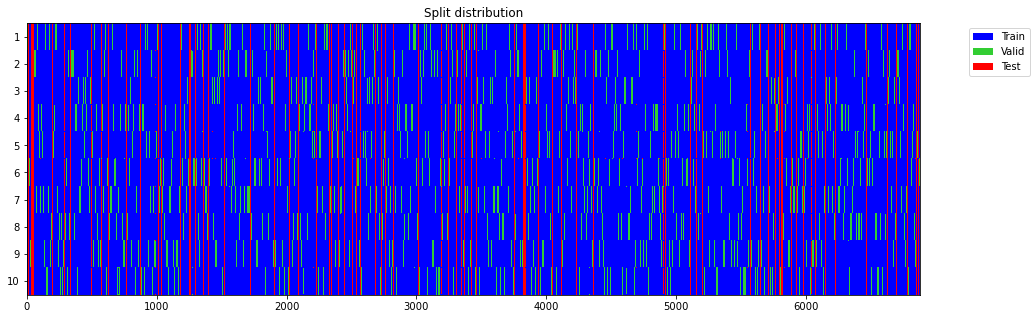

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [118]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.394099,0.306793,0.911685,0.638549,0.946833,0.279133,0.997966,0.430294,00:03
1,0.279634,0.237180,0.914737,0.692779,0.785207,0.400656,0.984903,0.529242,00:03
2,0.224035,0.191555,0.932867,0.744973,0.897571,0.497685,0.992261,0.639714,00:03
3,0.190926,0.158206,0.945073,0.802584,0.892685,0.615161,0.990007,0.728131,00:03
4,0.169028,0.149078,0.948483,0.831302,0.864907,0.677085,0.985518,0.759243,00:03
5,0.158829,0.147816,0.946868,0.811378,0.894023,0.632955,0.989802,0.740726,00:03
6,0.151673,0.160123,0.941483,0.796389,0.866848,0.605426,0.987352,0.712832,00:03
7,0.144710,0.147650,0.947586,0.822901,0.873292,0.658859,0.986943,0.750803,00:03
8,0.139046,0.157428,0.944714,0.815868,0.858500,0.646221,0.985515,0.736536,00:03
9,0.142478,0.145007,0.947765,0.833652,0.853207,0.683423,0.983882,0.758671,00:03


Better model found at epoch 0 with F1_multi value: 0.4302941560745239.


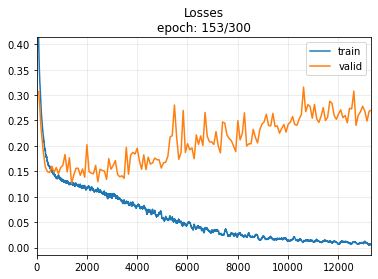

Better model found at epoch 1 with F1_multi value: 0.5292419791221619.
Better model found at epoch 2 with F1_multi value: 0.6397141814231873.
Better model found at epoch 3 with F1_multi value: 0.7281305193901062.
Better model found at epoch 4 with F1_multi value: 0.7592434287071228.
Better model found at epoch 15 with F1_multi value: 0.7882538437843323.
Better model found at epoch 27 with F1_multi value: 0.7913617491722107.
Better model found at epoch 31 with F1_multi value: 0.7990230321884155.
Better model found at epoch 39 with F1_multi value: 0.8139873743057251.
Better model found at epoch 145 with F1_multi value: 0.8158403635025024.
Better model found at epoch 150 with F1_multi value: 0.8216655254364014.


In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
              tfs.Normalize(),
              tfs.RandomShift(0.1),
              tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
              tfs.Scale(scale_factor=0.3)
             ]
for cv_num in range(5):
#     cv_num = cv_num + 5
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    # model = MiniRocketPlus(dls.vars, dls.c,2500)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)

    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[ShowGraph(),SaveModelCallback(monitor="F1_multi",fname="inception_augmented_%s"%cv_num)],
                    model_dir="models/10CV/")
    learn.fit_one_cycle(300, lr_max=0.008)
    learn.recorder.plot_metrics()

### check f1s

In [140]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
              tfs.Normalize(),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(5),
#               tfs.CutOutWhenTraining(),
              tfs.Scale(scale_factor=0.25)
             ]
reports = []
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("inception_augmented_%s"%cv_num)
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

In [143]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
pd.DataFrame(reports).median()

1st degree av block             0.845580
atrial fibrillation             0.944914
left bundle branch block        0.883721
premature atrial contraction    0.474787
right bundle branch block       0.934697
sinus rhythm                    0.731475
st depression                   0.777513
st elevation                    0.450000
ventricular ectopics            0.682671
micro avg                       0.807540
macro avg                       0.747561
weighted avg                    0.801740
samples avg                     0.780689
dtype: float64

In [148]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
inception = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.944,0.715,0.939,0.891,0.482,0.833,0.505, 0.709,0.789]))
inception_augmented = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.935,0.682,0.944,0.884,0.450,0.846,0.474, 0.731,0.778]))

winner = dict(sorted(winner.items()))
winner_ensemble = dict(sorted(winner_ensemble.items()))
inception = dict(sorted(inception.items()))
inception_augmented = dict(sorted(inception_augmented.items()))
df = pd.DataFrame([winner,winner_ensemble,inception,inception_augmented],index=["winner","winner_ensemble","inception","inception_augmented"]).T
df["performance"] = df["inception_augmented"]>df["winner"]
df

,winner,winner_ensemble,inception,inception_augmented,performance
AF,0.897,0.933,0.939,0.944,True
I-AVB,0.865,0.875,0.833,0.846,False
LBBB,0.821,0.884,0.891,0.884,True
PAC,0.734,0.826,0.505,0.474,False
PVC,0.852,0.869,0.715,0.682,False
RBBB,0.911,0.910,0.944,0.935,True
STD,0.788,0.811,0.789,0.778,False
STE,0.509,0.624,0.482,0.450,False
normal,0.795,0.808,0.709,0.731,False
